In [53]:
import os
import glob
import requests
import json
import re 
from tqdm import tqdm
from pprint import pprint
from time import sleep

import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib as mpl
import matplotlib.pyplot as plt

# request rate: 100 req/sec
SLEEP_SECONDS = 0.011

In [ ]:

offset=0
limit=1
headers = {"x-api-key": "5NNyAuuUBm4VAUZiEQOL85IeBVtNf9p3tpEPleoe"}
responces=[]

code_regex = re.compile('[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]')


In [ ]:
paths = glob.glob("/home/sibava/moonshot/acl-anthology/data/xml/*.xml")
papers = []

for path in paths:
    tree = ET.parse(path)
    root = tree.getroot()
    for k in root.iter("year"):
        year = k.text
    for k in root.iter("venue"):
        venue = k.text
    titles = []
    for k in root.iter("title"):
        if k.text == None:
            print(path)
        title = k.text.lower()
        titles.append(title)
        papers.append([title, venue, year])
    surveys = []

df = pd.DataFrame(data=papers,columns=["title","venue","year"])

In [ ]:
survey_df=df[df["title"].str.contains("survey")]

In [ ]:
titles = survey_df["title"]
for title in titles:
    title = code_regex.sub(' ',title)
    responce = requests.get(
    f"http://api.semanticscholar.org/graph/v1/paper/search?query={title}&offset={offset}&limit={limit}&fields=title,venue,fieldsOfStudy",headers=headers
    )
    txt = responce.text
    d = json.loads(txt)
    pprint(d)
    responces.append(d)
    sleep(SLEEP_SECONDS)

{'data': [{'fieldsOfStudy': None,
           'paperId': '0a036b156b1ca28ac4e564b1229a0726d689b442',
           'title': 'A basic survey of practical machine translation',
           'venue': 'BCS'}],
 'next': 1,
 'offset': 0,
 'total': 13}
{'data': [{'fieldsOfStudy': None,
           'paperId': 'ae460338410a73808bea68f01adc5843d3e7e9ea',
           'title': 'Continuing training for the language professions: a '
                    'survey of needs',
           'venue': 'TC'}],
 'offset': 0,
 'total': 1}
{'data': [{'fieldsOfStudy': ['Engineering'],
           'paperId': 'db7c3051f3f7c4c6a39dd356f6c2d9fbc38ed794',
           'title': 'A survey of termbanks worldwide',
           'venue': 'TC'}],
 'offset': 0,
 'total': 1}
{'data': [{'fieldsOfStudy': ['Computer Science'],
           'paperId': 'a4886a86ce5bc8ae785b5f1572a02d736cd6d917',
           'title': 'The Cambridge Language Survey',
           'venue': 'EAMT Workshop'}],
 'next': 1,
 'offset': 0,
 'total': 801}
{'data': [{'fieldsOfS

In [66]:
df = pd.DataFrame([r['data'][0] for r in responces if len(r["data"])!=0])

In [67]:
df.to_json('/home/sibava/moonshot/surveys.jsonl',orient="records",lines=True,force_ascii=False)

In [83]:
survey_df = pd.read_json("/home/sibava/moonshot/surveys.jsonl",orient="records",lines=True)

In [88]:
survey_df=survey_df.drop_duplicates(subset='paperId')

In [89]:
details=[]
for paperId in tqdm(survey_df['paperId']):
    responce = requests.get(
    f"http://api.semanticscholar.org/graph/v1/paper/{paperId}?fields=title,abstract,venue,year,referenceCount,citationCount,references,embedding",headers=headers
    )
    txt = responce.text
    d = json.loads(txt)
    details.append(d)

100%|██████████| 209/209 [01:50<00:00,  1.89it/s]


In [94]:
detail_df = pd.DataFrame(details)
is_referenced = detail_df.query("referenceCount>0")

In [95]:
is_referenced.to_json('/home/sibava/moonshot/references.jsonl',orient="records",lines=True,force_ascii=False)

In [48]:
is_referenced = pd.read_json('/home/sibava/moonshot/references.jsonl',orient="records",lines=True)
venue_dict = {
    "International Conference on Computational Linguistics":'COLING',
    "International Conference on Language Resources and Evaluation":"LREC",
    "Annual Meeting of the Association for Computational Linguistics":"ACL",
    "Computational Linguistics":"CL",
    "Conference on Empirical Methods in Natural Language Processing":"EMNLP",
    "North American Chapter of the Association for Computational Linguistics":"NAACL",
    "International Journal of Computational Linguistics and Chinese Language Processing":"IJCNLP",
    "Transactions of the Association for Computational Linguistics":"TACL",
}
pd.set_option('display.max_rows', 100)
pd.set_option("display.max_colwidth", 80)
is_referenced["venue"] = is_referenced["venue"].replace(venue_dict)
target_venue = ['LREC','CL','ACL','EMNLP',"NAACL",'COLING','AACL','TACL',"IJCNLP"]
selected = is_referenced[is_referenced['venue'].isin(target_venue)]
selected.to_json('/home/sibava/moonshot/selected_survey.jsonl',orient="records",lines=True,force_ascii=False)
references = selected['references'].explode()
reference_ids  = [x['paperId'] for x in references.to_list() if not x["paperId"] == None] #semantic scholarで見つけられない論文を除外

len(reference_ids)

6919

In [69]:
len(set(reference_ids))

5988

<AxesSubplot: >

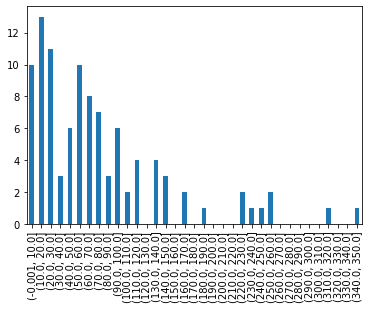

In [68]:
bins = np.linspace(0, 350, 36)
selected['referenceCount'].value_counts(bins=bins).sort_index().plot.bar(x="引用論文数")

In [142]:
vc = vc.sort_index()

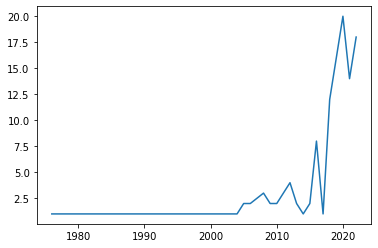

In [143]:
plt.plot(vc.index,vc.values)

In [128]:
reference_embs = []
for paperId in tqdm(reference_ids):
    responce = requests.get(
    f"http://api.semanticscholar.org/graph/v1/paper/{paperId}?fields=title,year,citationCount,embedding",headers=headers
    )
    txt = responce.text
    d = json.loads(txt)
    reference_embs.append(d)

 83%|████████▎ | 5100/6122 [37:27<07:30,  2.27it/s]  


OSError: Could not find a suitable TLS CA certificate bundle, invalid path: /home/sibava/miniconda3/envs/psat5/lib/python3.9/site-packages/certifi/cacert.pem